## Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pprint
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE

In [ ]:
!gsutil -m cp -r gs://kxc2105-nndl-fall-2021/src .

Copying gs://kxc2105-nndl-fall-2021/src/models/ae.py...
Copying gs://kxc2105-nndl-fall-2021/src/models/vae.py...
Copying gs://kxc2105-nndl-fall-2021/src/spike_sorting.py...


In [ ]:
!pip install omegaconf pytorch_lightning

In [ ]:
from pytorch_lightning import seed_everything, Trainer
from src.models.ae import *
from src.models.vae import *
from src.spike_sorting import *

## Data

In [ ]:
# !gsutil -m cp -r gs://kxc2105-nndl-fall-2021/experiments .

In [ ]:
!rm -rf data/clustering
!gsutil -m cp -r gs://kxc2105-nndl-fall-2021/data/clustering data/

Copying gs://kxc2105-nndl-fall-2021/data/clustering/20_cluster_templates.npy...
Copying gs://kxc2105-nndl-fall-2021/data/clustering/20_cluster_unit_idxs.npy...


## Clustering

In [ ]:
def clustering_analysis(system_cls, checkpoint, templates, clusters):
    model = system_cls.load_from_checkpoint(checkpoint)
    outputs = model(torch.tensor(templates).float())

    if system_cls == SpikeSortingPSVAE:
        supervised_latents = outputs[0].detach().numpy()
        unsupervised_latents = outputs[1].detach().numpy()
        reps = np.hstack((supervised_latents, unsupervised_latents))
    else:
        reps = outputs[0].detach().numpy()

    km = KMeans(n_clusters=20, random_state=4995).fit(reps)
    ari = adjusted_rand_score(km.labels_, clusters)
    
    z = TSNE(n_components=2, verbose=1, random_state=4995).fit_transform(reps)
    plt.figure()
    plt.scatter(z[:, 0], z[:, 1], cmap="tab20", c=clusters)
    plt.title(f"k-Means ARI = {ari:.3f}")
    plt.savefig(f"visualizations/{model.config['name']}/clustering.png")

    # Perform clustering with unsupervised latents only as well
    if system_cls == SpikeSortingPSVAE:
        reps = unsupervised_latents
        km = KMeans(n_clusters=20, random_state=4995).fit(reps)
        ari = adjusted_rand_score(km.labels_, clusters)
        
        z = TSNE(n_components=2, verbose=1, random_state=4995).fit_transform(reps)
        plt.figure()
        plt.scatter(z[:, 0], z[:, 1], cmap="tab20", c=clusters)
        plt.title(f"k-Means ARI = {ari:.3f} (Unsupervised Latents Only)")
        plt.savefig(f"visualizations/{model.config['name']}/unsupervised_latents_clustering.png")


In [233]:
templates = np.load("data/clustering/20_cluster_templates.npy").transpose((0, 2, 1))
clusters = np.load("data/clustering/20_cluster_unit_idxs.npy")

# Map cluster indices to new numbers
cluster_map = dict(zip(list(np.unique(clusters)), list(range(20))))
clusters = np.vectorize(cluster_map.get)(clusters)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.090737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.923698
[t-SNE] KL divergence after 1000 iterations: 0.184558
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.035266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.063461
[t-SNE] KL divergence after 1000 iterations: 0.208992


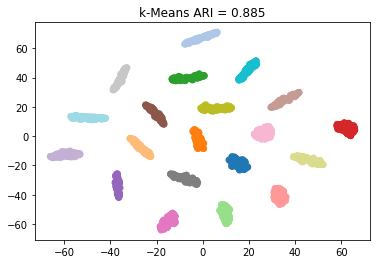

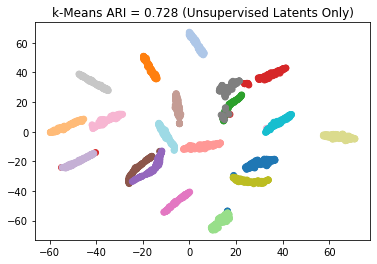

In [ ]:
clustering_analysis(
    SpikeSortingPSVAE,
    "experiments/psvae_latent_dim_selection/psvae_10latent_alpha=1_beta=20/model.ckpt",
    templates,
    clusters
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.090836
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.915874
[t-SNE] KL divergence after 1000 iterations: 0.194037


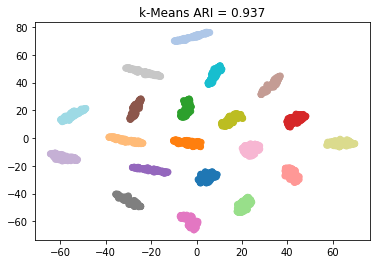

In [ ]:
clustering_analysis(
    SpikeSortingVAE,
    "experiments/vaes/vae_6latent/model.ckpt",
    templates,
    clusters
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.039425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.010330
[t-SNE] KL divergence after 1000 iterations: 0.157567


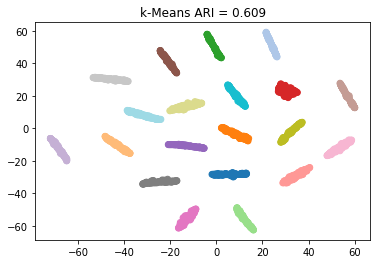

In [237]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=6)
reps = pca.fit_transform(templates.reshape(2000, -1))

km = KMeans(n_clusters=20, random_state=4995).fit(reps)
ari = adjusted_rand_score(km.labels_, clusters)

z = TSNE(n_components=2, verbose=1, random_state=4995).fit_transform(reps)
plt.figure()
plt.scatter(z[:, 0], z[:, 1], cmap="tab20", c=clusters)
plt.title(f"k-Means ARI = {ari:.3f}")
plt.savefig(f"visualizations/pca_clustering.png")

## Copy to Bucket

In [ ]:
!gcloud auth login
!gcloud config set project keen-bot-335318

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=r296z5VAMrEvoC0QGOO57Fj17bXGHP&prompt=consent&access_type=offline&code_challenge=pc1oK7hUT-S2uzVfo2VfVekax36Qg8vChbmJakmFEek&code_challenge_method=S256

Enter verification code: 4/1AX4XfWgNsSroUwJko9nlZF_h_cftkbDF7HOSteDn4IgvfQgA9m51yLqrnrg

You are now logged in as [kevinxchen13@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey

Updated property [core/proje

In [ ]:
!gsutil -m cp -r visualizations gs://kxc2105-nndl-fall-2021/

Copying file://visualizations/vae_8latent/reconstructions.pdf [Content-Type=application/pdf]...
Copying file://visualizations/vae_8latent/alpha_vs_8_latents.png [Content-Type=image/png]...
Copying file://visualizations/vae_8latent/x_vs_8_latents.png [Content-Type=image/png]...
Copying file://visualizations/psvae_8latent_alpha=1_beta=20/x_vs_8_latents.png [Content-Type=image/png]...
Copying file://visualizations/psvae_8latent_alpha=1_beta=20/y_vs_8_latents.png [Content-Type=image/png]...
Copying file://visualizations/vae_8latent/clustering.png [Content-Type=image/png]...
Copying file://visualizations/vae_8latent/y_vs_8_latents.png [Content-Type=image/png]...
Copying file://visualizations/psvae_10latent_alpha=1_beta=20/unsupervised_latents_clustering.png [Content-Type=image/png]...
Copying file://visualizations/psvae_8latent_alpha=1_beta=20/clustering.png [Content-Type=image/png]...
Copying file://visualizations/vae_8latent/z_vs_8_latents.png [Content-Type=image/png]...
Copying file://vi